The goal of my project is to examine the factors driving complaints about syringe litter in New York City.

In [2]:
# Install libraries
!pip install geodatasets

# Import libraries
from datetime import datetime
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# Data cleaning and exploratory data analysis

## Syringe complaints

In [3]:
# Download the 311 complaints about syringes
syringe_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?descriptor=Syringes&$limit=50000')
syringe_complaints.head(2)

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,64693962,2025-04-19T13:57:47.000,NaN,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,10454.0,431 EAST 138 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.808621,-73.921717,"\n, \n(40.808620539284995, -73.92171702201529)"
1,64701123,2025-04-19T10:27:47.000,NaN,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,10027.0,12 WEST 128 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.808621,-73.941563,"\n, \n(40.808621328272174, -73.94156321003942)"


In [4]:
# Convert created_date from an object to a date
syringe_complaints['created_date'] = pd.to_datetime(syringe_complaints['created_date'])

# Rename 'created_date' to 'created_datetime'
syringe_complaints = syringe_complaints.rename(columns = {'created_date': 'created_datetime'})

# Extract date, month, and year from 'created_datetime'
syringe_complaints['created_date'] = syringe_complaints['created_datetime'].dt.date
syringe_complaints['created_month'] = syringe_complaints['created_datetime'].dt.month
syringe_complaints['created_year'] = syringe_complaints['created_datetime'].dt.year

In [5]:
# Drop duplicate complaints (same date, latitude, and longitude)
syringe_complaints = syringe_complaints.drop_duplicates(subset = ['created_date', 'latitude', 'longitude'])
syringe_complaints.reset_index(drop = True, inplace = True)

In [6]:
# Look for missing values
syringe_complaints.isna().sum()

,0
unique_key,0
created_datetime,0
closed_date,7
agency,0
agency_name,0
complaint_type,0
descriptor,0
location_type,0
incident_zip,1
incident_address,1


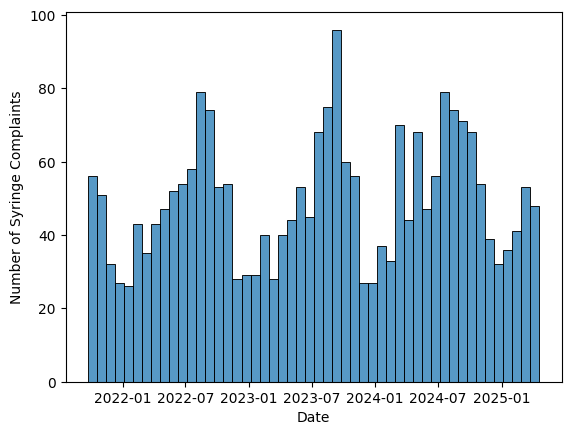

In [7]:
# Make a histogram to show the frequency of syringe complaints
ax = sns.histplot(data=syringe_complaints['created_datetime'], bins = 50)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Syringe Complaints')
plt.show()

Interesting finding: syringe complaints follow a cyclical trend, peaking at similar times each year!

In [8]:
# Look at the earliest and latest date
print(syringe_complaints['created_datetime'].min())
print(syringe_complaints['created_datetime'].max())

2021-09-22 09:01:47
2025-04-19 13:57:47


In [9]:
# Keep only complaints from 2022 to 2024 to make later analyses easier
syringe_complaints = syringe_complaints[(syringe_complaints['created_year']>=2022) & (syringe_complaints['created_year']<=2024)]

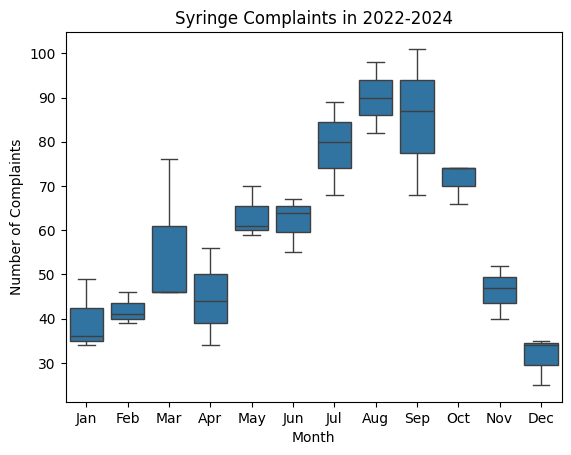

In [10]:
# Make a boxplot to show the number of syringe complaints each month
ax = sns.boxplot(data = syringe_complaints.groupby(['created_year', 'created_month'])['created_datetime'].agg(complaint_count = 'count').reset_index(),
                 x = 'created_month',
                 y = 'complaint_count')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Complaints')
plt.title('Syringe Complaints in 2022-2024')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

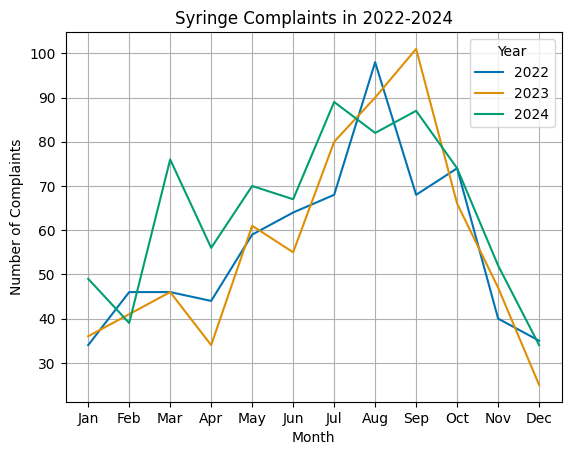

In [11]:
# Make a lineplot of the number of syringe complaints each month, with a different line pear year
ax = sns.lineplot(data = syringe_complaints.groupby(['created_year', 'created_month'])['created_datetime'].agg(complaint_count = 'count').reset_index(),
                  x = 'created_month',
                  y = 'complaint_count',
                  hue = 'created_year',
                  palette = 'colorblind')
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.title('Syringe Complaints in 2022-2024')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.show()

## Other types of 311 complaints

In [12]:
# Download all of the 311 complaints in 2022, 2023, and 2024
# To limit the size of the download, select only unique_key, created_date, complaint_type, descriptor, longitude, and latitude
all_311_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$query=SELECT%20unique_key,created_date,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude%20WHERE%20date_extract_y(created_date)IN(2022,2023,2024)%20LIMIT%2050000000')
all_311_complaints.head(2)

<ipython-input-12-6ce3a10b2812>:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  all_311_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$query=SELECT%20unique_key,created_date,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude%20WHERE%20date_extract_y(created_date)IN(2022,2023,2024)%20LIMIT%2050000000')


,unique_key,created_date,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude
0,55918463,2022-11-07T16:08:57.000,Street Condition,Pothole,89 STREET,11416.0,NaN,NaN
1,55918464,2022-11-07T15:27:24.000,Street Condition,Pothole,BEACH 12 STREET,11691.0,NaN,NaN


In [13]:
# Convert created_date from an object to a date
all_311_complaints['created_date'] = pd.to_datetime(all_311_complaints['created_date'])

# Rename 'created_date' to 'created_datetime'
all_311_complaints = all_311_complaints.rename(columns = {'created_date': 'created_datetime'})

# Extract date, month, and year from 'created_datetime'
all_311_complaints['created_date'] = all_311_complaints['created_datetime'].dt.date
all_311_complaints['created_month'] = all_311_complaints['created_datetime'].dt.month
all_311_complaints['created_year'] = all_311_complaints['created_datetime'].dt.year

In [14]:
# Remove duplicate complaints
all_311_complaints.drop_duplicates(subset = ['created_date', 'complaint_type', 'descriptor', 'incident_address', 'incident_zip', 'latitude', 'longitude'])
all_311_complaints.reset_index(drop = True, inplace = True)

In [15]:
# Group the 311 complaints by month and year
# Then count the complaints and just the syringe-related complaints
all_311_complaints_monthly = all_311_complaints.groupby(['created_year', 'created_month']).agg(
    all_complaints = ('descriptor', 'count'),
    syringe_complaints = ('descriptor', lambda x: (x == 'Syringes').sum()))

# Divide the syringe-related complaints by the total complaints
all_311_complaints_monthly['syringes/all (%)'] = 100 * all_311_complaints_monthly['syringe_complaints'] / all_311_complaints_monthly['all_complaints']
all_311_complaints_monthly.head(2)

all_complaints  syringe_complaints  \
created_year created_month                                       
2022         1                      272566                  34   
             2                      239223                  48   

                            syringes/all (%)  
created_year created_month                    
2022         1                      0.012474  
             2                      0.020065

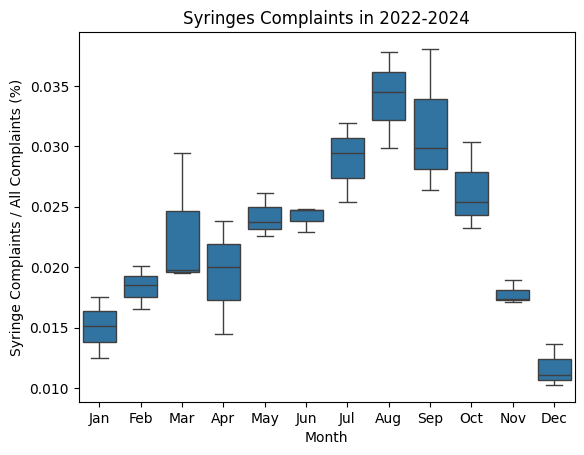

In [16]:
# Make a boxplot for syringes/all
order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ax = sns.boxplot(data = all_311_complaints_monthly,
                 x = 'created_month',
                 y = 'syringes/all (%)',
                 order = order)
ax.set_xlabel('Month')
ax.set_ylabel('Syringe Complaints / All Complaints (%)')
plt.title('Syringes Complaints in 2022-2024')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [17]:
# Delete all_311_complaints_monthly
del all_311_complaints_monthly

## Geographic distribution

In [18]:
# Drop columns that won't be needed
all_311_complaints = all_311_complaints.drop(columns = ['incident_address', 'incident_zip'])

In [19]:
all_311_complaints

,unique_key,created_datetime,complaint_type,descriptor,longitude,latitude,created_date,created_month,created_year
0,55918463,2022-11-07 16:08:57,Street Condition,Pothole,NaN,NaN,2022-11-07,11,2022
1,55918464,2022-11-07 15:27:24,Street Condition,Pothole,NaN,NaN,2022-11-07,11,2022
2,56038110,2022-11-19 21:11:46,Obstruction,Weeds or Grass,-73.776716,40.596924,2022-11-19,11,2022
3,56122854,2022-11-29 13:11:51,Street Condition,Pothole,NaN,NaN,2022-11-29,11,2022
4,63432788,2024-12-17 12:53:00,Water System,Dirty Water (WE),-73.910120,40.683770,2024-12-17,12,2024
...,...,...,...,...,...,...,...,...,...
9853707,55739607,2022-10-18 22:31:59,Street Condition,Pothole,NaN,NaN,2022-10-18,10,2022
9853708,63451339,2024-12-18 12:02:58,General Construction/Plumbing,Site Conditions Endangering Workers,-73.958971,40.673683,2024-12-18,12,2024
9853709,61973579,2024-07-30 21:25:00,Street Light Condition,Traffic Signal Light,-73.784555,40.697330,2024-07-30,7,2024
9853710,62774263,2024-10-16 17:50:00,Water Quality,unknown odor/taste in drinking water (QA6),-73.818624,40.831195,2024-10-16,10,2024


In [20]:
# Drop rows that do not have latitude and longitude data
all_311_complaints = all_311_complaints.dropna(subset = ['latitude', 'longitude'], how = 'any', ignore_index = True)

In [21]:
# Convert all_311_complaints into a GeoDataFrame in the NAD83 / New York Long Island (ftUS) coordinate reference system
all_311_complaints = gpd.GeoDataFrame(all_311_complaints,
                                      geometry = gpd.points_from_xy(all_311_complaints.longitude, all_311_complaints.latitude),
                                      crs = 'EPSG:4326')
all_311_complaints = all_311_complaints.to_crs(2263)

In [22]:
# Load map of NYC for plotting, CRS = 2263 (NAD83 / New York Long Island (ftUS))
nyc = gpd.read_file(geodatasets.get_path('nybb'))
nyc.crs

Extracting 'nybb_16a/nybb.shp' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.shx' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.dbf' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.prj' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'


<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US survey foot)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

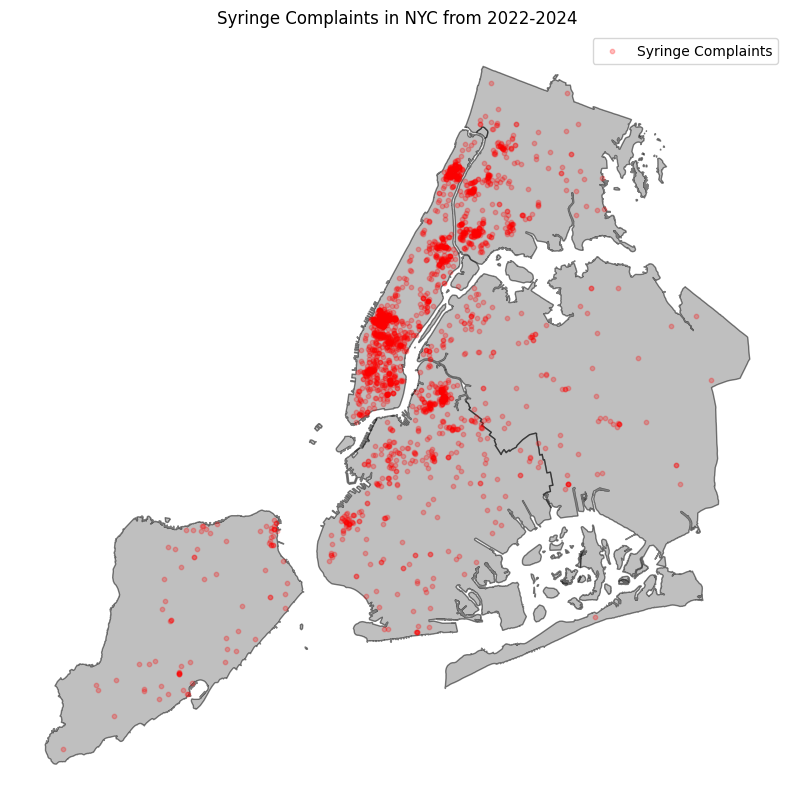

In [23]:
# Plot the syringe complaints on a map of NYC
ax = nyc.plot(figsize = (10, 10), alpha = 0.5, color = 'gray', edgecolor = 'k')

# Plot the syringe complaints
all_311_complaints[all_311_complaints['descriptor']=='Syringes'].plot(ax = ax, markersize = 10, alpha = 0.25, color = 'red')

# Format the plot
ax.set_axis_off()
ax.legend(['Syringe Complaints'])
plt.title('Syringe Complaints in NYC from 2022-2024')
plt.show()

In [24]:
# Download the sharps dropoff site data
dropoff_sites = pd.read_csv('https://data.cityofnewyork.us/resource/edk2-vkjh.csv')
dropoff_sites.head(2)

,borough,ntaname,site_type,sitename,zipcode,phonenum,days_hours,address,borocd,notes,...,councildist,senate_district,_congress_district,assembly_district,police_precints,bbl,bin,latitude,longitude,point
0,Bronx,Norwood,SYRINGE/SHARPS Drop-off,North Central Bronx Hospital,10467,718-918-5000,24/7,"3424 Kossuth Ave, Bronx, NY 10467",207,Lobby,...,11,33,15,81,52,2.033270e+09,2017787.0,40.880432,-73.881204,POINT (-73.881205418129 40.8804402931774)
1,Queens,Flushing-Willets Point,SYRINGE/SHARPS Drop-off,Union Plaza Care Center,11354,718-670-0765,10am-2pm,"33-23 Union St. Flushing, NY 11354",407,Lobby,...,20,16,6,40,109,4.049810e+09,4112550.0,40.767323,-73.826924,POINT (-73.8269253950036 40.7673312732314)


In [25]:
# Keep only the sharps dropoff sites
dropoff_sites = dropoff_sites[dropoff_sites['site_type'] == 'SYRINGE/SHARPS Drop-off']

# Keep only the relevant columns in dropoff_sites
dropoff_sites = dropoff_sites[['sitename', 'days_hours', 'latitude', 'longitude']]
dropoff_sites = dropoff_sites.reset_index(drop = True)

In [26]:
# Look at the values in the 'days_hours' column
dropoff_sites['days_hours'].value_counts()

,count
days_hours,
24/7,26
Monday-Friday 9am-5pm,19
9am-5pm,14
Monday-Friday 8am-4pm,7
10am-4pm,4
...,...
Monday-Thursday 10am-3pm,1
Monday-Sunday 11am-1pm,1
"Monday, Tuesday, Friday 9am-5pm; Wednesday 10AM-5PM; Thursday 9AM-7PM",1


In [27]:
# Use Google's Gemini LLM to parse the 'days_hours' column into something more quantifiable

# Import the necessary libraries
from IPython.display import HTML, Markdown, display
from google.colab import userdata
from google.api_core import retry
from google import genai
from pydantic import BaseModel

# Get the Google API key
GOOGLE_API_KEY = userdata.get('google_api_key')

# Handle errors
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})
genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

# Initialize the genAI client
client = genai.Client(api_key=GOOGLE_API_KEY)

# Define what the LLM's response should look like
class Response(BaseModel):
  logical: str
  hours_per_month: int

# For each dropoff site, ask whether the dropoff hours make sense
# If so, calculate the hours the site is open in a 28-day month
for i in range(len(dropoff_sites)):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      contents=f'''The site hours are {dropoff_sites.loc[i, 'days_hours']}. Does this make logical sense, Yes or No?
      How many hours in a 28-day month is the site open?''',
      config={
          'response_mime_type': 'application/json',
          'response_schema': list[Response],
      },
  )

  # Save the calculated hours
  if response.parsed[0].logical == 'Yes':
    dropoff_sites.loc[i, 'hours_per_month'] = response.parsed[0].hours_per_month
  else:
    dropoff_sites.loc[i, 'hours_per_month'] = np.nan

  # Track progress
  if i % 50 == 0:
    print(f'Progress: {i} rows')

Progress: 0 rows
Progress: 50 rows
Progress: 100 rows
Progress: 150 rows


In [28]:
dropoff_sites.head(2)

,sitename,days_hours,latitude,longitude,hours_per_month
0,North Central Bronx Hospital,24/7,40.880432,-73.881204,672.0
1,Union Plaza Care Center,10am-2pm,40.767323,-73.826924,112.0


In [29]:
# Turn dropoff_sites into a GeoDataFrame
dropoff_sites = gpd.GeoDataFrame(dropoff_sites,
                                 geometry = gpd.points_from_xy(dropoff_sites.longitude, dropoff_sites.latitude),
                                 crs = 'EPSG:4326')
dropoff_sites = dropoff_sites.to_crs(2263)

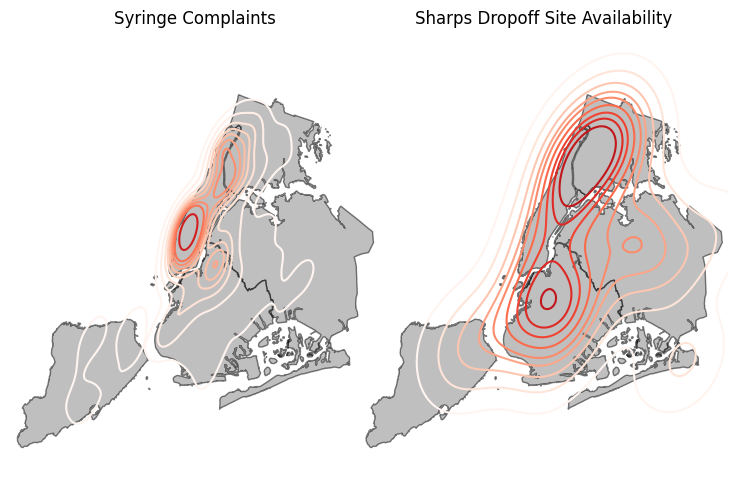

In [46]:
# Plot dropoff locations and syringe locations side by side
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

# Plot syringe complaints on one subplot
subplot1 = nyc.plot(ax = axes[0], alpha = 0.5, color = 'gray', edgecolor = 'k')
sns.kdeplot(x = all_311_complaints[all_311_complaints['descriptor']=='Syringes'].geometry.x,
            y = all_311_complaints[all_311_complaints['descriptor']=='Syringes'].geometry.y,
            cmap = 'Reds',
            ax=axes[0])

# Plot dropoff sites on the other subplot
subplot2 = nyc.plot(ax = axes[1], alpha = 0.5, color = 'gray', edgecolor = 'k')
sns.kdeplot(x = dropoff_sites.geometry.x, y = dropoff_sites.geometry.y,
            weights = dropoff_sites['hours_per_month']/672,
            cmap = 'Reds',
            ax=axes[1])

# Format the plot
subplot1.set_axis_off()
subplot2.set_axis_off()

# Set x and y limits
axes[0].set_xlim(0.91e6, 1.07e6)
axes[0].set_ylim(100000, 300000)
axes[1].set_xlim(0.91e6, 1.07e6)
axes[1].set_ylim(100000, 300000)

# Title each subplot
axes[0].set_title('Syringe Complaints')
axes[1].set_title('Sharps Dropoff Site Availability')
plt.subplots_adjust(wspace = -0.4)
plt.show()

# Feature engineering

In [31]:
# Load neighborhood tabulation area (NTA) data
!wget https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/neighborhood-tabulation-areas/nynta2020_25a.zip -O nta.zip
!unzip nta.zip

nta = gpd.read_file('/content/nynta2020_25a/nynta2020.shp')
nta = nta.to_crs(2263)
nta.head(2)

--2025-04-23 00:32:45--  https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/neighborhood-tabulation-areas/nynta2020_25a.zip
Resolving s-media.nyc.gov (s-media.nyc.gov)... 23.60.17.170, 2600:1407:7400:1088::1500, 2600:1407:7400:108a::1500
Connecting to s-media.nyc.gov (s-media.nyc.gov)|23.60.17.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 989198 (966K) [application/zip]
Saving to: ‘nta.zip’

nta.zip             100%[===================>] 966.01K  --.-KB/s    in 0.06s   

2025-04-23 00:32:45 (15.0 MB/s) - ‘nta.zip’ saved [989198/989198]

Archive:  nta.zip
  inflating: nynta2020_25a/nynta2020.shp  
  inflating: nynta2020_25a/nynta2020.dbf  
  inflating: nynta2020_25a/nynta2020.shx  
  inflating: nynta2020_25a/nynta2020.prj  
  inflating: nynta2020_25a/nynta2020.shp.xml  


,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geometry
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28919.562151,3.532181e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ..."
1,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026805,2.885431e+07,"POLYGON ((995851.915 203199.332, 995969.192 20..."


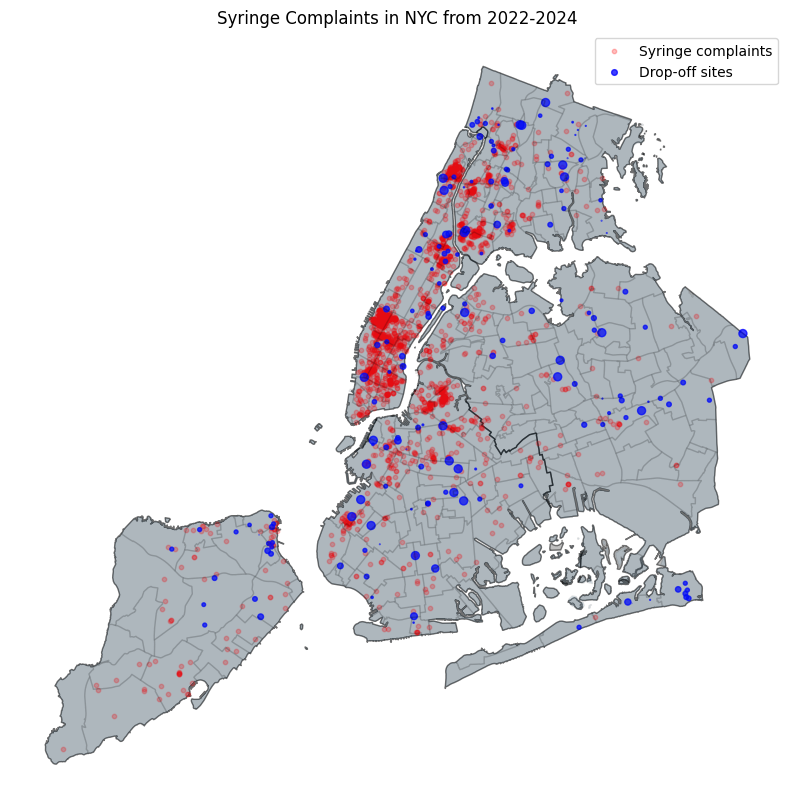

In [41]:
# Plot the syringe complaints, dropoff sites, and NTAs on a map of NYC
ax = nyc.plot(figsize = (10, 10), alpha = 0.5, color = 'gray', edgecolor = 'k')

# Plot the syringe complaints
all_311_complaints[all_311_complaints['descriptor']=='Syringes'].plot(ax = ax, markersize = 10, alpha = 0.25, color = 'red')

# Plot the dropoff sites
dropoff_sites.plot(ax = ax, markersize = dropoff_sites['hours_per_month']*0.05, alpha = 0.75, color = 'blue')

# Plot the NTAs
nta.plot(ax = ax, edgecolor = 'k', alpha = 0.1)

# Format the plot
ax.set_axis_off()
ax.legend(['Syringe complaints', 'Drop-off sites'])
plt.title('Syringe Complaints in NYC from 2022-2024')
plt.show()

In [33]:
# Spatial join all_311_complaints and nta
all_311_complaints = all_311_complaints.sjoin(nta[['NTA2020', 'geometry']], how = 'left')

In [ ]:
# For each complaint in all_311_complaints, test whether that complaint correlates with syringe complaints
for complaint in list(set(all_311_complaints['complaint_type'])):
  complaints_by_nta = all_311_complaints.groupby('NTA2020').agg(all = ('unique_key', 'count'),
                                                           syringes = ('descriptor', lambda x: (x == 'Syringes').sum()),
                                                           other = ('complaint_type', lambda x: (x == complaint).sum()))

  test_corr = stats.pearsonr(complaints_by_nta['syringes']/complaints_by_nta['all'],
                             complaints_by_nta['other']/complaints_by_nta['all'])
  if (test_corr[0] > 0.4) & (test_corr[1] < 0.01):
    print(complaint, test_corr)

Encampment PearsonRResult(statistic=np.float64(0.5125469379404188), pvalue=np.float64(5.931761878863399e-19))
Bench PearsonRResult(statistic=np.float64(0.4001613115185977), pvalue=np.float64(1.70267573034337e-11))
Panhandling PearsonRResult(statistic=np.float64(0.5180539313567547), pvalue=np.float64(2.1497433933130173e-19))
Homeless Person Assistance PearsonRResult(statistic=np.float64(0.4041279309716148), pvalue=np.float64(1.0284041818537595e-11))


In [43]:
# Group all_311_complaints by NTA and calculate the following:
# All complaints
# Syringe complaints
# Encampment complaints
# Bench complaints
# Panhandling complaints
# Homeless person assistance complaints
complaints_by_nta = all_311_complaints.groupby('NTA2020').agg(all_complaints = ('unique_key', 'count'),
                                                              syringe_complaints = ('descriptor', lambda x: (x == 'Syringes').sum()),
                                                              encampment_complaints = ('complaint_type', lambda x: (x == 'Encampment').sum()),
                                                              bench_complaints = ('complaint_type', lambda x: (x == 'Bench').sum()),
                                                              panhandling_complaints = ('complaint_type', lambda x: (x == 'Panhandling').sum()),
                                                              homeless_assistance_complaints = ('complaint_type', lambda x: (x == 'Homeless Person Assistance').sum()))

In [44]:
# Divide each category by all_complaints
complaints_by_nta['syringes/all (%)'] = 100 * complaints_by_nta['syringe_complaints'] / complaints_by_nta['all_complaints']
complaints_by_nta['encampments/all (%)'] = 100 * complaints_by_nta['encampment_complaints'] / complaints_by_nta['all_complaints']
complaints_by_nta['benches/all (%)'] = 100 * complaints_by_nta['bench_complaints'] / complaints_by_nta['all_complaints']
complaints_by_nta['panhandling/all (%)'] = 100 * complaints_by_nta['panhandling_complaints'] / complaints_by_nta['all_complaints']
complaints_by_nta['homeless assistance/all (%)'] = 100 * complaints_by_nta['homeless_assistance_complaints'] / complaints_by_nta['all_complaints']

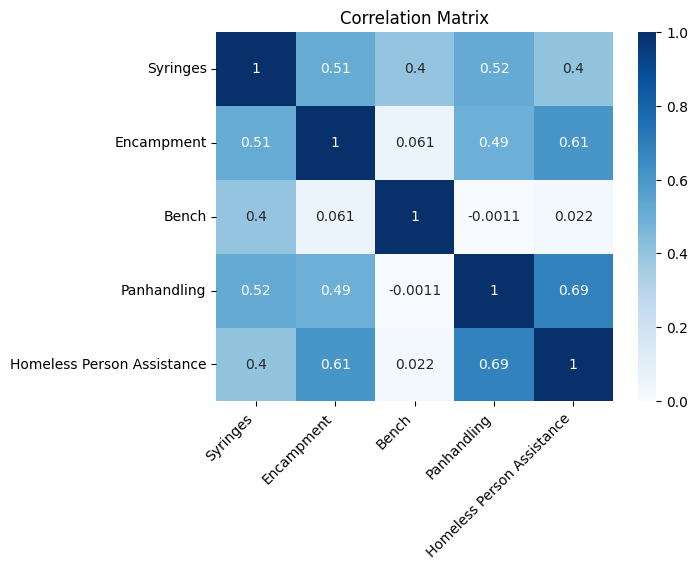

In [45]:
# Plot the correlation matrix between syringe complaints and the other complaint categories, divided by all complaints
fig, ax = plt.subplots()
sns.heatmap(complaints_by_nta[['syringes/all (%)',
                               'encampments/all (%)',
                               'benches/all (%)',
                               'panhandling/all (%)',
                               'homeless assistance/all (%)']].corr(),
            cmap = 'Blues', annot = True)
ax.set_title('Correlation Matrix')
ax.set_xticklabels(['Syringes', 'Encampment', 'Bench', 'Panhandling', 'Homeless Person Assistance'], rotation = 45, ha = 'right')
ax.set_yticklabels(['Syringes', 'Encampment', 'Bench', 'Panhandling', 'Homeless Person Assistance'])
plt.show()